# KerasCV starter notebook [Train] on Google Lab

Adopted from [KerasCV starter notebook [Train]](https://https://www.kaggle.com/code/jihoonkim2100/kerascv-starter-notebook-train)

- GPU 설정 : Runtime -> Change runtim type -> A100 GPU <br>
- 드라이브 연결 : Mount drive

In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 16.6 MB/s eta 0:00:00


In [ ]:
pwd()

'/content'

## Setup and Imports

In [ ]:
import os
# You can use `tensorflow`, `pytorch`, `jax` here
# KerasCore makes the notebook backend agnostic :)
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import keras_core as keras
from keras_core import layers

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend


## Configuration

In [ ]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 64
    EPOCHS = 10
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

## Reproducibility

In [ ]:
keras.utils.set_random_seed(seed=config.SEED)

RSNA-ATD: 512x512 PNG v2 Dataset downloaded from the [open dataset link](https://https://www.kaggle.com/datasets/awsaf49/rsna-atd-512x512-png-v2-dataset)

In [ ]:
pip install keras_efficientnet

In [ ]:
# %cd /content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset

# !unzip -qq "/content/drive/MyDrive/test/archive.zip"

In [ ]:
from glob import glob

data = sorted(glob('/content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset/train_images/*/*/*.png'))
print(len(data))

11536


In [ ]:
BASE_PATH = '/content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset'

In [ ]:
# train
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")
dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

In [ ]:
dataframe.head(10)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/content/drive/MyDrive/test/rsna-atd-512x512-p...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/content/drive/MyDrive/test/rsna-atd-512x512-p...,512,512
2,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,364,Active_Extravasation,/content/drive/MyDrive/test/rsna-atd-512x512-p...,512,512
3,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,365,Active_Extravasation,/content/drive/MyDrive/test/rsna-atd-512x512-p...,512,512
4,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,366,Active_Extravasation,/content/drive/MyDrive/test/rsna-atd-512x512-p...,512,512
5,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,367,Active_Extravasation,/content/drive/MyDrive/test/rsna-atd-512x512-p...,512,512
6,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,368,Active_Extravasation,/content/drive/MyDrive/test/rsna-atd-512x512-p...,512,512
7,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,369,Active_Extravasation,/content/drive/MyDrive/test/rsna-atd-512x512-p...,512,512
8,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,370,Active_Extravasation,/content/drive/MyDrive/test/rsna-atd-512x512-p...,512,512
9,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,371,Active_Extravasation,/content/drive/MyDrive/test/rsna-atd-512x512-p...,512,512


In [ ]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [ ]:
train_data.shape, val_data.shape

((9612, 21), (2417, 21))

In [ ]:
train_data.columns

Index(['patient_id', 'bowel_healthy', 'bowel_injury', 'extravasation_healthy',
       'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high', 'any_injury', 'series_id',
       'instance_number', 'injury_name', 'image_path', 'width', 'height'],
      dtype='object')

## Data Pipeline /w tf.data

In [ ]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.cast(label, tf.float32)
    #         bowel       fluid       kidney      liver       spleen
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])

    return (image, labels)

def apply_augmentation(images, labels):
    augmenter = keras_cv.layers.Augmenter(
        [
        #    keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2),

        ]
    )
    return (augmenter(images), labels)


def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [ ]:
image_path = train_data.image_path[1]
print(image_path)
file_bytes = tf.io.read_file(image_path)
image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
print(image.shape)
print(config.IMAGE_SIZE)
print(train_data.image_path.tolist())

/content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset/train_images/32272/13774/35.png
(512, 512, 3)
[256, 256]
['/content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset/train_images/32272/13774/61.png', '/content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset/train_images/32272/13774/35.png', '/content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset/train_images/32272/13774/66.png', '/content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset/train_images/32272/13774/53.png', '/content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset/train_images/32272/13774/55.png', '/content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset/train_images/32272/13774/51.png', '/content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset/train_images/32272/13774/57.png', '/content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset/train_images/32272/13774/41.png', '/content/drive/MyDrive/test/rsna-atd-512x512-png-v2-dataset/train_images/32272/13774/44.png', '/content/drive/MyDrive/tes

In [ ]:
paths  = train_data.image_path.to_list()
labels = train_data[config.TARGET_COLS].values

ds = build_dataset(paths, labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([64, 256, 256, 3]),
 [TensorShape([64, 1]),
  TensorShape([64, 1]),
  TensorShape([64, 3]),
  TensorShape([64, 3]),
  TensorShape([64, 3])])

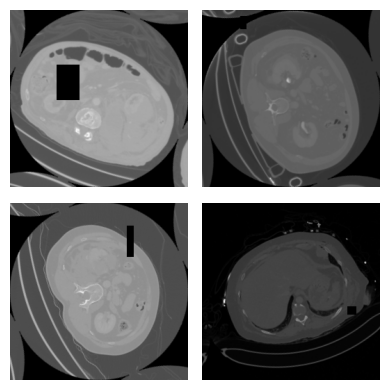

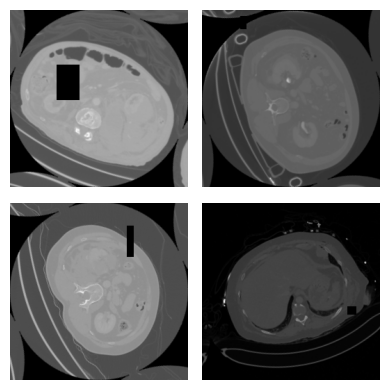

In [ ]:
# No more customizing your plots by hand, KerasCV has your back ;)
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=2,
    cols=2,
)

## Build Model

In [ ]:
def build_model(warmup_steps, decay_steps):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)

    # Define Backbone
    # Use EfficientNetB5 as the backbone
    backbone = keras_efficientnet.EfficientNetB5(include_top=False, input_tensor=inputs, weights='imagenet')
    x = backbone.output

    # GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # Define 'necks' for each head
    x_bowel = keras.layers.Dense(32, activation='silu')(x)
    x_extra = keras.layers.Dense(32, activation='silu')(x)
    x_liver = keras.layers.Dense(32, activation='silu')(x)
    x_kidney = keras.layers.Dense(32, activation='silu')(x)
    x_spleen = keras.layers.Dense(32, activation='silu')(x)

    # Define heads
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel) # use sigmoid to convert predictions to [0-1]
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra) # use sigmoid to convert predictions to [0-1]
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver) # use softmax for the liver head
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney) # use softmax for the kidney head
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen) # use softmax for the spleen head

    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    print("[INFO] Building the model...")
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = {
        "bowel": keras.losses.BinaryCrossentropy(),
        "extra": keras.losses.BinaryCrossentropy(),
        "liver": keras.losses.CategoricalCrossentropy(),
        "kidney": keras.losses.CategoricalCrossentropy(),
        "spleen": keras.losses.CategoricalCrossentropy(),
    }
    metrics = {
        "bowel": ["accuracy"],
        "extra": ["accuracy"],
        "liver": ["accuracy"],
        "kidney": ["accuracy"],
        "spleen": ["accuracy"],
    }
    print("[INFO] Compiling the model...")
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    return model


## Train the model with "model.fit"

In [ ]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=96640
warmup_steps=9664
decay_steps=86976


In [ ]:
# build the model
print("[INFO] Building the model...")
model = build_model(warmup_steps, decay_steps)

# train
print("[INFO] Training...")
history = model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
)

[INFO] Building the model...


NameError: ignored

## Visualize the training plots

In [ ]:
# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [ ]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

### Store the model for inference

In [ ]:
# Save the model
model.save("rsna-atd.keras")